Input datasets:
- training_data_MS_iso_filter.csv
- training_data_MS_filter.csv
- training_data.csv

This notebook includes:
- Test for significance and FDR
- Feature correlation
- Violin plots (continuous features)
- Barplots (categorical features)

# Import libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import seaborn as sns
import os

from scipy.stats import mannwhitneyu, chi2_contingency, fisher_exact
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.multitest import fdrcorrection
from matplotlib_venn import venn2
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

# Define paths

In [2]:
Data_path = os.path.dirname(os.getcwd()) + '/Data'

# Import dataset

### Feature datasets

In [3]:
df_MS_iso_filter = pd.read_csv(Data_path + '/training/training_data_MS_iso_filter.csv')
df_MS_filter = pd.read_csv(Data_path + '/training/training_data_MS_filter.csv')
df_no_filter = pd.read_csv(Data_path + '/training/training_data_no_filter.csv')

In [4]:
print("Proteins in MS & isolation method filtered dataset:", len(df_MS_iso_filter))
print("Proteins in MS filtered dataset:", len(df_MS_filter))
print("Proteins in unfiltered dataset:", len(df_no_filter))

Proteins in MS & isolation method filtered dataset: 16255
Proteins in MS filtered dataset: 13709
Proteins in unfiltered dataset: 16929


In [5]:
EV_MS_iso_1 = df_MS_iso_filter[df_MS_iso_filter["EV"] == 1]
EV_MS_iso_0 = df_MS_iso_filter[df_MS_iso_filter["EV"] == 0]

EV_MS_1 = df_MS_filter[df_MS_filter["EV"] == 1]
EV_MS_0 = df_MS_filter[df_MS_filter["EV"] == 0]

EV_none_1 = df_no_filter[df_no_filter["EV"] == 1]
EV_none_0 = df_no_filter[df_no_filter["EV"] == 0]

# Feature analysis

In [6]:
features_continuous = ['length', 'hydr_count', 'polar_count', 'molecular_weight',
       'helix', 'turn', 'sheet', 'A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K',
       'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y', 'thsa_netsurfp2',
       'tasa_netsurfp2', 'rhsa_netsurfp2', 'disorder', 'A_exposed',
       'C_exposed', 'D_exposed', 'E_exposed', 'F_exposed', 'G_exposed',
       'H_exposed', 'I_exposed', 'K_exposed', 'L_exposed', 'M_exposed',
       'N_exposed', 'P_exposed', 'Q_exposed', 'R_exposed', 'S_exposed',
       'T_exposed', 'V_exposed', 'W_exposed', 'Y_exposed',
       'Prob. of Solubility', 'Aggregation_propensity', 'Aromaticity',
       'Instability_index', 'Gravy', 'isoelectric_point', 'charge_at_7',
       'charge_at_5', 'Polar_exposed', 'Hydrophobic_exposed']

features_categorical = ['HSP', 'PTM_UP', 'Citrullination_UP', 'GPI-anchor_UP', 
       'Nitration_UP', 'Prenylation_UP', 'ISGylation_UP',
       'NEDDylation_UP', 'Acetylation_all', 'Glycosylation_all',
       'Methylation_all', 'Myristoylation_all', 'Nitrosylation_all',
       'Palmitoylation_all', 'Phosphorylation_all', 'SUMOylation_all',
       'Ubiquitination_all', 'PTM_MSD', 'Phosphorylation_MSD',
       'Glycosylation_MSD', 'Ubiquitination_MSD', 'SUMOylation_MSD',
       'Acetylation_MSD', 'Palmitoylation_MSD', 'Methylation_MSD',
       'coiled_coil', 'RAS_profile', 'ww_domain', 'EGF', 'RRM', 'transmembrane', 'TMHMM']

### Discovery set

In [7]:
# continuous features

# create Series to save p-values
p_vals = pd.Series(index=features_continuous, dtype="float64", name="p_value")

# calculate p-values using Mann-Whitney U Test
for i, feature in enumerate(features_continuous):
    stat, p = mannwhitneyu(EV_MS_iso_1[feature], EV_MS_iso_0[feature]) # function return statistic and p-value
    p_vals[i] = p 

# calculate adjusted p-value (FDR correction)
rejected, p_vals_adj = fdrcorrection(p_vals)
# create Series to save adjusted p-values
p_vals_adj = pd.Series(data=p_vals_adj, index=features_continuous, name="p_value_adjusted")
# save both p-values in dataframe
p_vals_comb_MS_iso = pd.concat([p_vals, p_vals_adj], axis=1)


# categorical features

# create Series to save p-values
p_vals_cat = pd.Series(index=features_categorical, dtype="float64", name="p_value")

# calculate p-values using Fisher's exact test
for i, feature in enumerate(features_categorical):
    # get counts for each category
    A = sum(EV_MS_iso_1[feature]) # EV & positive
    B = len(EV_MS_iso_1[feature]) - sum(EV_MS_iso_1[feature]) # EV & negative
    C = sum(EV_MS_iso_0[feature]) # no EV & positive
    D = len(EV_MS_iso_0[feature]) - sum(EV_MS_iso_0[feature]) # no EV & negative
    
    # create 2x2 contingency table of counts
    table = np.array([[A, B],
                      [C, D]])
    odds, p = fisher_exact(table, alternative="two-sided") # function return odds ratio and p-value
    p_vals_cat[i] = p 

# calculate adjusted p-value (FDR correction)
rejected, p_vals_adj_cat = fdrcorrection(p_vals_cat)
# create Series to save adjusted p-values
p_vals_adj_cat = pd.Series(data=p_vals_adj_cat, index=features_categorical, name="p_value_adjusted")
# save both p-values in dataframe
p_vals_comb_MS_iso_cat = pd.concat([p_vals_cat, p_vals_adj_cat], axis=1)

# concat both p-value dataframes
p_vals_comb_MS_iso = pd.concat([p_vals_comb_MS_iso, p_vals_comb_MS_iso_cat], axis=0)
p_vals_comb_MS_iso[:5]

,p_value,p_value_adjusted
length,9.904864e-04,1.098540e-03
hydr_count,8.538383e-47,2.250894e-46
polar_count,1.857209e-11,2.697375e-11
molecular_weight,1.211611e-03,1.319791e-03
helix,3.290009e-36,7.167519e-36


In [8]:
p_vals_comb_MS_iso.to_csv(Data_path + '/P_vals.csv')

### MS + count filtered dataset

In [9]:
# continuous features

# create Series to save p-values
p_vals = pd.Series(index=features_continuous, dtype="float64", name="p_value")

# calculate p-values using Mann-Whitney U Test
for i, feature in enumerate(features_continuous):
    stat, p = mannwhitneyu(EV_MS_1[feature], EV_MS_0[feature]) # function return statistic and p-value
    p_vals[i] = p 

# calculate adjusted p-value (FDR correction)
rejected, p_vals_adj = fdrcorrection(p_vals)
# create Series to save adjusted p-values
p_vals_adj = pd.Series(data=p_vals_adj, index=features_continuous, name="p_value_adjusted")
# save both p-values in dataframe
p_vals_comb_MS = pd.concat([p_vals, p_vals_adj], axis=1)


# categorical features

# create Series to save p-values
p_vals_cat = pd.Series(index=features_categorical, dtype="float64", name="p_value")

# calculate p-values using Fisher's exact test
for i, feature in enumerate(features_categorical):
    # get counts for each category
    A = sum(EV_MS_1[feature]) # EV & positive
    B = len(EV_MS_1[feature]) - sum(EV_MS_1[feature]) # EV & negative
    C = sum(EV_MS_0[feature]) # no EV & positive
    D = len(EV_MS_0[feature]) - sum(EV_MS_0[feature]) # no EV & negative
    
    # create 2x2 contingency table of counts
    table = np.array([[A, B],
                      [C, D]])
    odds, p = fisher_exact(table, alternative="two-sided") # function return odds ratio and p-value
    p_vals_cat[i] = p 

# calculate adjusted p-value (FDR correction)
rejected, p_vals_adj_cat = fdrcorrection(p_vals_cat)
# create Series to save adjusted p-values
p_vals_adj_cat = pd.Series(data=p_vals_adj_cat, index=features_categorical, name="p_value_adjusted")
# save both p-values in dataframe
p_vals_comb_MS_cat = pd.concat([p_vals_cat, p_vals_adj_cat], axis=1)

# concat both p-value dataframes
p_vals_comb_MS = pd.concat([p_vals_comb_MS, p_vals_comb_MS_cat], axis=0)

### Count filtered dataset

In [10]:
# continuous features

# create Series to save p-values
p_vals = pd.Series(index=features_continuous, dtype="float64", name="p_value")

# calculate p-values using Mann-Whitney U Test
for i, feature in enumerate(features_continuous):
    stat, p = mannwhitneyu(EV_none_1[feature], EV_none_0[feature]) # function return statistic and p-value
    p_vals[i] = p 

# calculate adjusted p-value (FDR correction)
rejected, p_vals_adj = fdrcorrection(p_vals)
# create Series to save adjusted p-values
p_vals_adj = pd.Series(data=p_vals_adj, index=features_continuous, name="p_value_adjusted")
# save both p-values in dataframe
p_vals_comb_none = pd.concat([p_vals, p_vals_adj], axis=1)


# categorical features

# create Series to save p-values
p_vals_cat = pd.Series(index=features_categorical, dtype="float64", name="p_value")

# calculate p-values using Fisher's exact test
for i, feature in enumerate(features_categorical):
    # get counts for each category
    A = sum(EV_none_1[feature]) # EV & positive
    B = len(EV_none_1[feature]) - sum(EV_none_1[feature]) # EV & negative
    C = sum(EV_none_0[feature]) # no EV & positive
    D = len(EV_none_0[feature]) - sum(EV_none_0[feature]) # no EV & negative
    
    # create 2x2 contingency table of counts
    table = np.array([[A, B],
                      [C, D]])
    odds, p = fisher_exact(table, alternative="two-sided") # function return odds ratio and p-value
    p_vals_cat[i] = p 

# calculate adjusted p-value (FDR correction)
rejected, p_vals_adj_cat = fdrcorrection(p_vals_cat)
# create Series to save adjusted p-values
p_vals_adj_cat = pd.Series(data=p_vals_adj_cat, index=features_categorical, name="p_value_adjusted")
# save both p-values in dataframe
p_vals_comb_none_cat = pd.concat([p_vals_cat, p_vals_adj_cat], axis=1)

# concat both p-value dataframes
p_vals_comb_none = pd.concat([p_vals_comb_none, p_vals_comb_none_cat], axis=0)

# Feature correlation

In [11]:
# calculate pairwise correlation
corr_all = df_MS_iso_filter.corr()

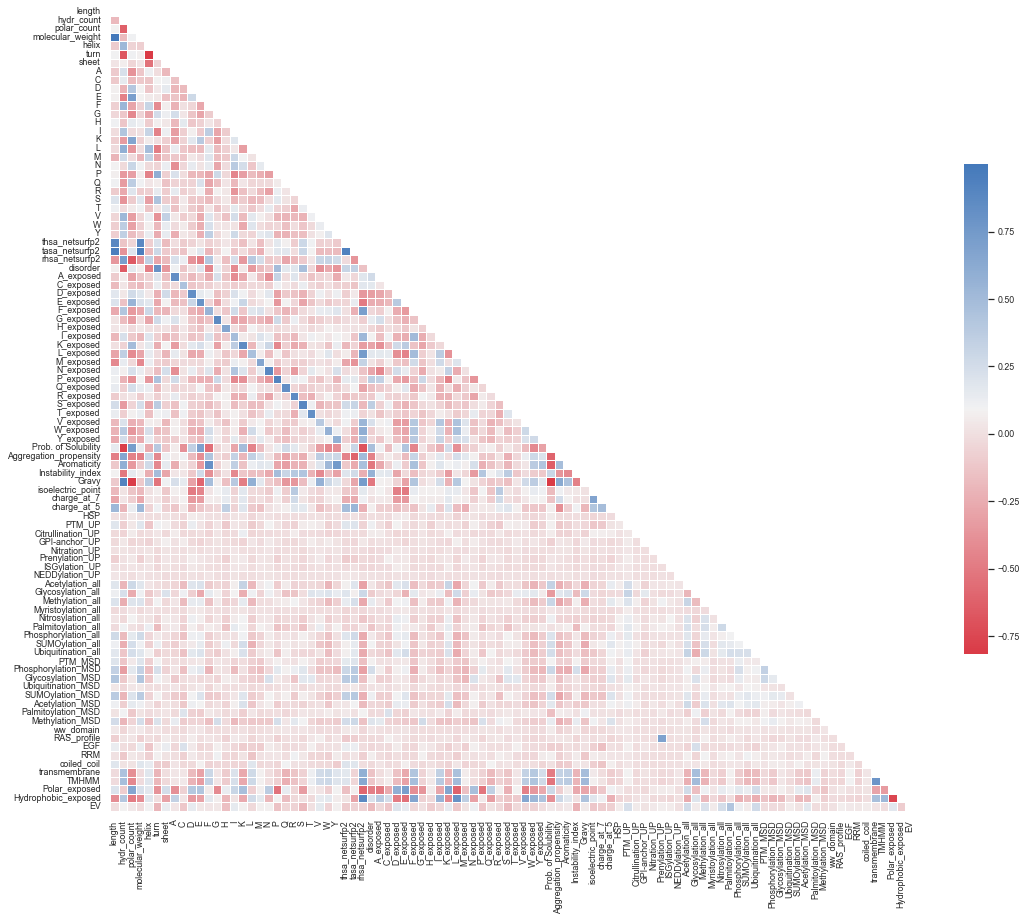

In [12]:
# figure settings
sns.set(font_scale=0.8)
mask = np.triu(np.ones_like(corr_all, dtype=np.bool))
sns.set_style(style="white")

fig, ax = plt.subplots(figsize=(18, 18))
cmap = sns.diverging_palette(10, 250, as_cmap=True)
sns.heatmap(corr_all, mask=mask, cmap=cmap, square=True, linewidths=.5, cbar_kws={"shrink": .5}, ax=ax,
            xticklabels=True, yticklabels=True);

Text(0.5, 1.0, 'Correlation of features with EV')

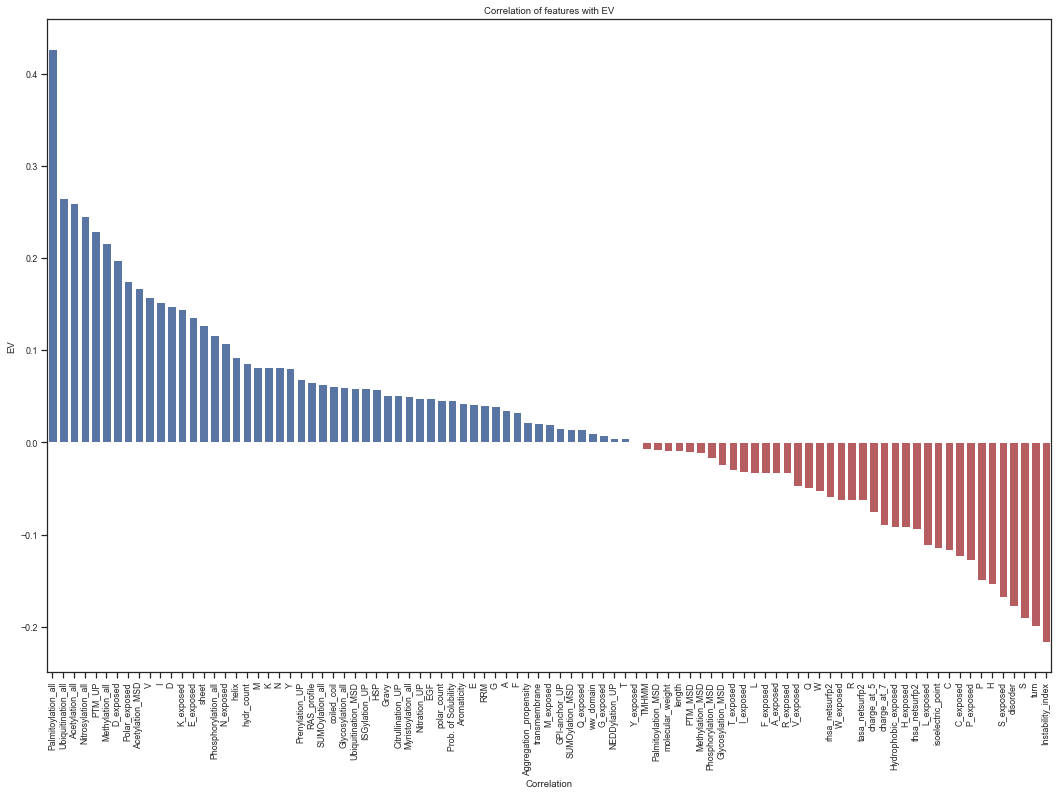

In [13]:
# figure settings
sns.set(style=("ticks"), font_scale=0.8)

correlations_all = corr_all[["EV"]].sort_values(by="EV", ascending=False)[1:]
correlations_all.reset_index(inplace=True)

colors_all = ["b" if (x > 0) else "r" for x in correlations_all["EV"]]

fig = plt.figure(figsize=(18, 12)) 
sns.barplot(x="index", y="EV", data=correlations_all, palette=colors_all)
plt.xlabel("Features") 
plt.xticks(rotation=90)
plt.xlabel("Correlation")
plt.title("Correlation of features with EV")

### PTM Barplots

In [14]:
ptm_cols = ['PTM_UP', 'Citrullination_UP', 'GPI-anchor_UP',
       'Nitration_UP', 'Prenylation_UP', 'ISGylation_UP', 'NEDDylation_UP',
       'Acetylation_all', 'Glycosylation_all', 'Methylation_all',
       'Myristoylation_all', 'Nitrosylation_all', 'Palmitoylation_all',
       'Phosphorylation_all', 'SUMOylation_all', 'Ubiquitination_all',
       'coiled_coil', 'EGF', 'RAS_profile', 'RRM', 'ww_domain']

def get_ptm_dataframes(df, ptm_cols):
    
    df_PTM = df[ptm_cols + ["EV"]]
    
    # create subsets of PTM dataframe
    df_PTM_1 = df_PTM[df_PTM["EV"] == 1]
    df_PTM_0 = df_PTM[df_PTM["EV"] == 0]

    # drop vesicle column
    df_PTM_1.drop(columns=["EV"], inplace=True)
    df_PTM_0.drop(columns=["EV"], inplace=True)
    
    return df_PTM_1, df_PTM_0

df_MS_iso_PTM_1, df_MS_iso_PTM_0 = get_ptm_dataframes(df_MS_iso_filter, ptm_cols)
df_MS_PTM_1, df_MS_PTM_0 = get_ptm_dataframes(df_MS_filter, ptm_cols)
df_none_PTM_1, df_none_PTM_0 = get_ptm_dataframes(df_no_filter, ptm_cols)

In [15]:
def create_melted_ptm_dataframe(df_1, df_0):
    
    df_fraction = pd.DataFrame(data={'PTM': df_1.columns, 
                                  'EV':df_1.sum().values/len(df_1), 
                                  'non-EV':df_0.sum().values/len(df_0)})
    df_melted = df_fraction.melt(id_vars=["PTM"], var_name="Vesicle", value_name="Fraction")
    df_melted.sort_values(["PTM", "Vesicle"], inplace=True)    
    
    return df_melted

# create melted dataframe of all PTM fractions in EV and non-EV group
df_MS_iso_PTM_melted = create_melted_ptm_dataframe(df_MS_iso_PTM_1, df_MS_iso_PTM_0)
df_MS_PTM_melted = create_melted_ptm_dataframe(df_MS_PTM_1, df_MS_PTM_0)
df_none_PTM_melted = create_melted_ptm_dataframe(df_none_PTM_1, df_none_PTM_0)

In [16]:
# combine results dataframes for one PTM type
def create_subset(ptm, df_list):
    
    df_ptm_list = []
    
    for df in df_list:
        df_ptm = df[df["PTM"].str.contains(ptm)]
        df_ptm_list.append(df_ptm)
    
    # concatenate into one dataframe
    df_combined_ptm = pd.concat(df_ptm_list)
    
    return df_combined_ptm

create_subset("Palmitoylation_all", [df_MS_iso_PTM_melted, df_MS_PTM_melted, df_none_PTM_melted])

,PTM,Vesicle,Fraction
12,Palmitoylation_all,EV,0.443588
33,Palmitoylation_all,non-EV,0.080758
12,Palmitoylation_all,EV,0.361186
33,Palmitoylation_all,non-EV,0.068227
12,Palmitoylation_all,EV,0.357873
33,Palmitoylation_all,non-EV,0.052576


In [17]:
def print_p_val(p_val):
    
    if p_val < 0.0001:
        return "< 0.0001"
    else:
        return "%.4f" % p_val

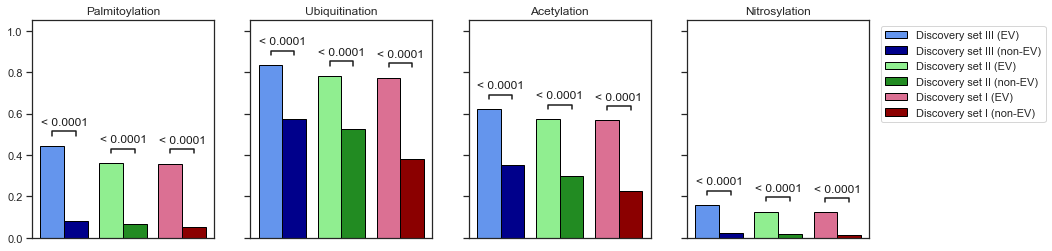

In [18]:
# create subsets of dataframes for PTM types to be plotted
PTMs = ["Palmitoylation_all", "Ubiquitination_all", "Acetylation_all", "Nitrosylation_all"]
names_PTMs = ["Palmitoylation", "Ubiquitination", "Acetylation", "Nitrosylation"]
subsets = []
for i in PTMs:
    subset = create_subset(i, [df_MS_iso_PTM_melted, df_MS_PTM_melted, df_none_PTM_melted])
    subsets.append(subset)

# figure settings
sns.set(style=("ticks"), font_scale=1)
fig, axs = plt.subplots(1, 4, sharey=True, figsize=(15, 4))
plt.ylim((0, 1.05))   

x1 = [1, 3, 5]
x2 = [1.8, 3.8, 5.8]

for i, data in enumerate(subsets):
    axs[i].bar([1, 1.8, 3, 3.8, 5, 5.8], data["Fraction"], color=["cornflowerblue", "darkblue", "lightgreen", "forestgreen",
        "palevioletred", "darkred"], edgecolor="black")
    axs[i].set(xlabel=None, ylabel=None, title=names_PTMs[i], xticks=[])
    y, h = data['Fraction'].iloc[0] + 0.05, 0.02
    axs[i].plot([1, 1, 1.8, 1.8], [y, y+h, y+h, y], lw=1.5, c='k')
    axs[i].text((1+1.8)*0.5, y+h+0.02, print_p_val(p_vals_comb_MS_iso.loc[PTMs[i], "p_value_adjusted"]), ha='center', 
        va='bottom', color='k')
    y, h = data['Fraction'].iloc[2] + 0.05, 0.02
    axs[i].plot([3, 3, 3.8, 3.8], [y, y+h, y+h, y], lw=1.5, c='k')
    axs[i].text((3+3.8)*.5, y+h+0.02, print_p_val(p_vals_comb_MS.loc[PTMs[i], "p_value_adjusted"]), ha='center', va='bottom', 
        color='k')
    y, h = data['Fraction'].iloc[4] + 0.05, 0.02
    axs[i].plot([5, 5, 5.8, 5.8], [y, y+h, y+h, y], lw=1.5, c='k')
    axs[i].text((5+5.8)*.5, y+h+0.02, print_p_val(p_vals_comb_none.loc[PTMs[i], "p_value_adjusted"]), ha='center', 
        va='bottom', color='k')   
    # add legend outside of plots
    if i == 3:
        axs[i].legend(handles=axs[i].patches, labels=["Discovery set III (EV)", "Discovery set III (non-EV)",
            "Discovery set II (EV)", "Discovery set II (non-EV)", "Discovery set I (EV)", "Discovery set I (non-EV)", ], 
                      bbox_to_anchor=(2, 1))
        
plt.show()

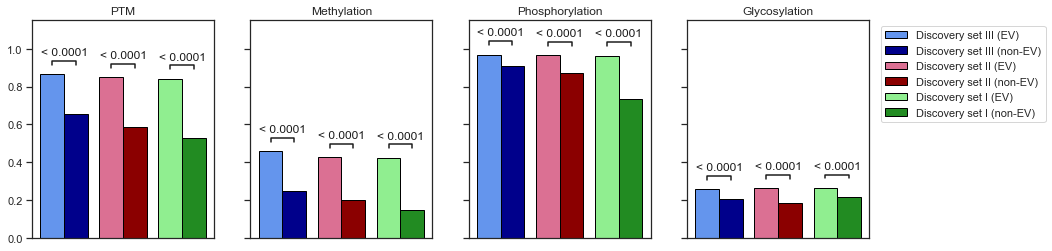

In [19]:
# create subsets of dataframes for PTM types to be plotted
PTMs = ["PTM_UP", "Methylation_all", "Phosphorylation_all", "Glycosylation_all"]
names_PTMs = ["PTM", "Methylation", "Phosphorylation", "Glycosylation"]
subsets = []
for i in PTMs:
    subset = create_subset(i, [df_MS_iso_PTM_melted, df_MS_PTM_melted, df_none_PTM_melted])
    subsets.append(subset)

# figure settings
sns.set(style=("ticks"), font_scale=1)
fig, axs = plt.subplots(1, 4, sharey=True, figsize=(15, 4))
plt.ylim((0, 1.15))   

x1 = [1, 3, 5]
x2 = [1.8, 3.8, 5.8]

for i, data in enumerate(subsets):
    axs[i].bar([1, 1.8, 3, 3.8, 5, 5.8], data["Fraction"], color=["cornflowerblue", "darkblue", "palevioletred", "darkred", 
        "lightgreen", "forestgreen"], edgecolor="black")
    axs[i].set(xlabel=None, ylabel=None, title=names_PTMs[i], xticks=[])
    y, h = data['Fraction'].iloc[0] + 0.05, 0.02
    axs[i].plot([1, 1, 1.8, 1.8], [y, y+h, y+h, y], lw=1.5, c='k') 
    axs[i].text((1+1.8)*0.5, y+h+0.02, print_p_val(p_vals_comb_MS_iso.loc[PTMs[i], "p_value_adjusted"]), ha='center', va='bottom', color='k')
    y, h = data['Fraction'].iloc[2] + 0.05, 0.02
    axs[i].plot([3, 3, 3.8, 3.8], [y, y+h, y+h, y], lw=1.5, c='k')
    axs[i].text((3+3.8)*.5, y+h+0.02, print_p_val(p_vals_comb_MS.loc[PTMs[i], "p_value_adjusted"]), ha='center', va='bottom', color='k')
    y, h = data['Fraction'].iloc[4] + 0.05, 0.02
    axs[i].plot([5, 5, 5.8, 5.8], [y, y+h, y+h, y], lw=1.5, c='k')
    axs[i].text((5+5.8)*.5, y+h+0.02, print_p_val(p_vals_comb_none.loc[PTMs[i], "p_value_adjusted"]), ha='center', va='bottom', color='k') 
    
    # add legend outside of plots
    if i == 3:
        axs[i].legend(handles=axs[i].patches, labels=["Discovery set III (EV)", "Discovery set III (non-EV)",
            "Discovery set II (EV)", "Discovery set II (non-EV)", "Discovery set I (EV)", "Discovery set I (non-EV)", ], 
                      bbox_to_anchor=(2, 1))
          
plt.show()

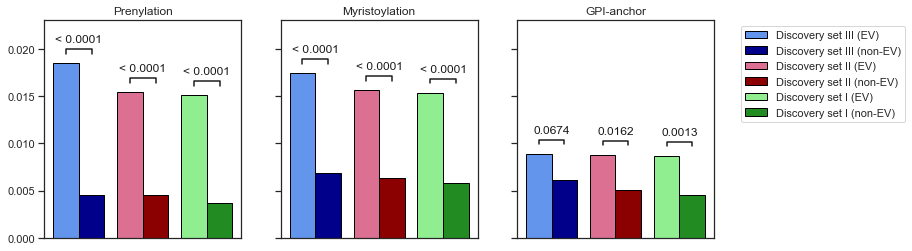

In [20]:
# create subsets of dataframes for PTM types to be plotted
PTMs = ["Prenylation_UP", "Myristoylation_all", "GPI-anchor_UP"]
names_PTMs = ["Prenylation", "Myristoylation", "GPI-anchor"]
subsets = []
for i in PTMs:
    subset = create_subset(i, [df_MS_iso_PTM_melted, df_MS_PTM_melted, df_none_PTM_melted])
    subsets.append(subset)

# figure settings
sns.set(style=("ticks"), font_scale=1)
fig, axs = plt.subplots(1, 3, sharey=True, figsize=(12, 4))
plt.ylim((0, 0.023))   

x1 = [1, 3, 5]
x2 = [1.8, 3.8, 5.8]

for i, data in enumerate(subsets):
    axs[i].bar([1, 1.8, 3, 3.8, 5, 5.8], data["Fraction"], color=["cornflowerblue", "darkblue", "palevioletred", "darkred", 
        "lightgreen", "forestgreen"], edgecolor="black")
    axs[i].set(xlabel=None, ylabel=None, title=names_PTMs[i], xticks=[])
    y, h = data['Fraction'].iloc[0] + 0.001, 0.0005
    axs[i].plot([1, 1, 1.8, 1.8], [y, y+h, y+h, y], lw=1.5, c='k') 
    axs[i].text((1+1.8)*0.5, y+h*2, print_p_val(p_vals_comb_MS_iso.loc[PTMs[i], "p_value_adjusted"]), ha='center', 
        va='bottom', color='k')
    y, h = data['Fraction'].iloc[2] + 0.001, 0.0005
    axs[i].plot([3, 3, 3.8, 3.8], [y, y+h, y+h, y], lw=1.5, c='k')
    axs[i].text((3+3.8)*.5, y+h*2, print_p_val(p_vals_comb_MS.loc[PTMs[i], "p_value_adjusted"]), ha='center', va='bottom',
        color='k')
    y, h = data['Fraction'].iloc[4] + 0.001, 0.0005
    axs[i].plot([5, 5, 5.8, 5.8], [y, y+h, y+h, y], lw=1.5, c='k')
    axs[i].text((5+5.8)*.5, y+h*2, print_p_val(p_vals_comb_none.loc[PTMs[i], "p_value_adjusted"]), ha='center', va='bottom',
        color='k')   
    # add legend outside of plots
    if i == 2:
        axs[i].legend(handles=axs[i].patches, labels=["Discovery set III (EV)", "Discovery set III (non-EV)",
            "Discovery set II (EV)", "Discovery set II (non-EV)", "Discovery set I (EV)", "Discovery set I (non-EV)", ], 
                      bbox_to_anchor=(2, 1))

plt.show()

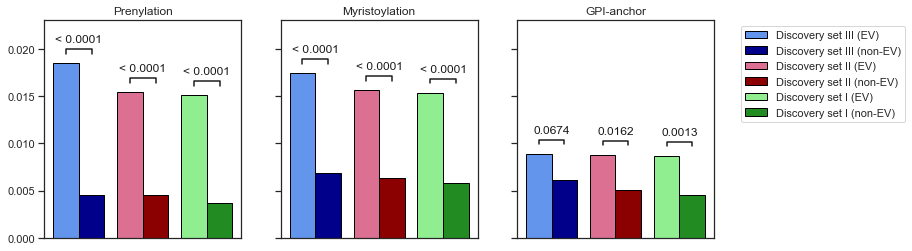

In [21]:
# create subsets of dataframes for PTM types to be plotted
PTMs = ["Prenylation_UP", "Myristoylation_all", "GPI-anchor_UP"]
names_PTMs = ["Prenylation", "Myristoylation", "GPI-anchor"]
subsets = []
for i in PTMs:
    subset = create_subset(i, [df_MS_iso_PTM_melted, df_MS_PTM_melted, df_none_PTM_melted])
    subsets.append(subset)

# figure settings
sns.set(style=("ticks"), font_scale=1)
fig, axs = plt.subplots(1, 3, sharey=True, figsize=(12, 4))
plt.ylim((0, 0.023))   

x1 = [1, 3, 5]
x2 = [1.8, 3.8, 5.8]

for i, data in enumerate(subsets):
    axs[i].bar([1, 1.8, 3, 3.8, 5, 5.8], data["Fraction"], color=["cornflowerblue", "darkblue", "palevioletred", "darkred", 
        "lightgreen", "forestgreen"], edgecolor="black")
    axs[i].set(xlabel=None, ylabel=None, title=names_PTMs[i], xticks=[])
    y, h = data['Fraction'].iloc[0] + 0.001, 0.0005
    axs[i].plot([1, 1, 1.8, 1.8], [y, y+h, y+h, y], lw=1.5, c='k') 
    axs[i].text((1+1.8)*0.5, y+h*2, print_p_val(p_vals_comb_MS_iso.loc[PTMs[i], "p_value_adjusted"]), ha='center', 
        va='bottom', color='k')
    y, h = data['Fraction'].iloc[2] + 0.001, 0.0005
    axs[i].plot([3, 3, 3.8, 3.8], [y, y+h, y+h, y], lw=1.5, c='k')
    axs[i].text((3+3.8)*.5, y+h*2, print_p_val(p_vals_comb_MS.loc[PTMs[i], "p_value_adjusted"]), ha='center', va='bottom',
        color='k')
    y, h = data['Fraction'].iloc[4] + 0.001, 0.0005
    axs[i].plot([5, 5, 5.8, 5.8], [y, y+h, y+h, y], lw=1.5, c='k')
    axs[i].text((5+5.8)*.5, y+h*2, print_p_val(p_vals_comb_none.loc[PTMs[i], "p_value_adjusted"]), ha='center', va='bottom',
        color='k')   
    # add legend outside of plots
    if i == 2:
        axs[i].legend(handles=axs[i].patches, labels=["Discovery set III (EV)", "Discovery set III (non-EV)",
            "Discovery set II (EV)", "Discovery set II (non-EV)", "Discovery set I (EV)", "Discovery set I (non-EV)", ], 
                      bbox_to_anchor=(2, 1))

plt.show()

#### Domain barplots

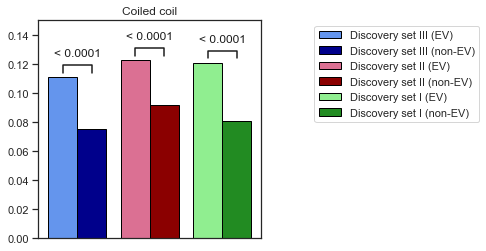

In [22]:
# create subsets of dataframes for PTM types to be plotted
PTMs = ['coiled_coil']       
names_PTMs = ['Coiled coil']
subsets = []
for i in PTMs:
    subset = create_subset(i, [df_MS_iso_PTM_melted, df_MS_PTM_melted, df_none_PTM_melted])
    subsets.append(subset)

# figure settings
sns.set(style=("ticks"), font_scale=1)
fig, axs = plt.subplots(1, 1, sharey=True, figsize=(4, 4))
plt.ylim((0, 0.15))   

x1 = [1, 3, 5]
x2 = [1.8, 3.8, 5.8]

for i, data in enumerate(subsets):
    axs.bar([1, 1.8, 3, 3.8, 5, 5.8], data["Fraction"], color=["cornflowerblue", "darkblue", "palevioletred", "darkred", 
        "lightgreen", "forestgreen"], edgecolor="black")
    axs.set(xlabel=None, ylabel=None, title=names_PTMs[i], xticks=[])
    y, h = data['Fraction'].iloc[0] + 0.003, 0.005
    axs.plot([1, 1, 1.8, 1.8], [y, y+h, y+h, y], lw=1.5, c='k') 
    axs.text((1+1.8)*0.5, y+h*2, print_p_val(p_vals_comb_MS_iso.loc[PTMs[i], "p_value_adjusted"]), ha='center', 
        va='bottom', color='k')
    y, h = data['Fraction'].iloc[2] + 0.003, 0.005
    axs.plot([3, 3, 3.8, 3.8], [y, y+h, y+h, y], lw=1.5, c='k')
    axs.text((3+3.8)*.5, y+h*2, print_p_val(p_vals_comb_MS.loc[PTMs[i], "p_value_adjusted"]), ha='center', va='bottom',
        color='k')
    y, h = data['Fraction'].iloc[4] + 0.003, 0.005
    axs.plot([5, 5, 5.8, 5.8], [y, y+h, y+h, y], lw=1.5, c='k')
    axs.text((5+5.8)*.5, y+h*2, print_p_val(p_vals_comb_none.loc[PTMs[i], "p_value_adjusted"]), ha='center', va='bottom',
        color='k')   
    # add legend outside of plots
    if i == 0:
        axs.legend(handles=axs.patches, labels=["Discovery set III (EV)", "Discovery set III (non-EV)",
            "Discovery set II (EV)", "Discovery set II (non-EV)", "Discovery set I (EV)", "Discovery set I (non-EV)", ], 
                      bbox_to_anchor=(2, 1))

plt.show()

#### Structural features

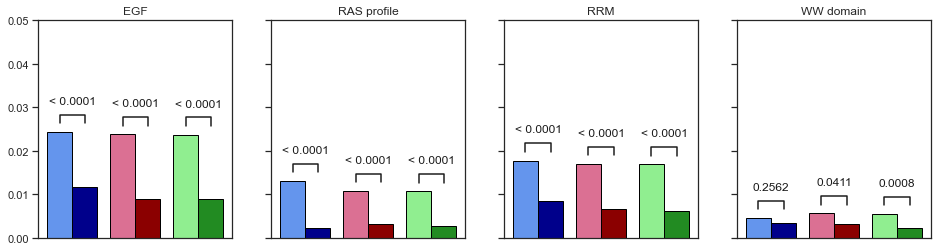

In [23]:
# create subsets of dataframes for PTM types to be plotted
PTMs = ['EGF', 'RAS_profile', 'RRM', 'ww_domain']       
names_PTMs = ['EGF', 'RAS profile', 'RRM', 'WW domain']
subsets = []
for i in PTMs:
    subset = create_subset(i, [df_MS_iso_PTM_melted, df_MS_PTM_melted, df_none_PTM_melted])
    subsets.append(subset)

# figure settings
sns.set(style=("ticks"), font_scale=1)
fig, axs = plt.subplots(1, 4, sharey=True, figsize=(16, 4))
plt.ylim((0, 0.05))   

x1 = [1, 3, 5]
x2 = [1.8, 3.8, 5.8]

for i, data in enumerate(subsets):
    axs[i].bar([1, 1.8, 3, 3.8, 5, 5.8], data["Fraction"], color=["cornflowerblue", "darkblue", "palevioletred", "darkred", 
        "lightgreen", "forestgreen"], edgecolor="black")
    axs[i].set(xlabel=None, ylabel=None, title=names_PTMs[i], xticks=[])
    y, h = data['Fraction'].iloc[0] + 0.002, 0.002
    axs[i].plot([1, 1, 1.8, 1.8], [y, y+h, y+h, y], lw=1.5, c='k') 
    axs[i].text((1+1.8)*0.5, y+h*2, print_p_val(p_vals_comb_MS_iso.loc[PTMs[i], "p_value_adjusted"]), ha='center', 
        va='bottom', color='k')
    y, h = data['Fraction'].iloc[2] + 0.002, 0.002
    axs[i].plot([3, 3, 3.8, 3.8], [y, y+h, y+h, y], lw=1.5, c='k')
    axs[i].text((3+3.8)*.5, y+h*2, print_p_val(p_vals_comb_MS.loc[PTMs[i], "p_value_adjusted"]), ha='center', va='bottom',
        color='k')
    y, h = data['Fraction'].iloc[4] + 0.002, 0.002
    axs[i].plot([5, 5, 5.8, 5.8], [y, y+h, y+h, y], lw=1.5, c='k')
    axs[i].text((5+5.8)*.5, y+h*2, print_p_val(p_vals_comb_none.loc[PTMs[i], "p_value_adjusted"]), ha='center', va='bottom',
        color='k')   

plt.show()

## Physicochemical and structural features violinplots

In [24]:
# figure settings
sns.set(style=("ticks"), font_scale=1.2)
x1, x2 = 0, 1 
my_pal = {1: "cornflowerblue", 0: "darkblue"}
dataset = df_MS_iso_filter
labels = ["EV", "non-EV"]

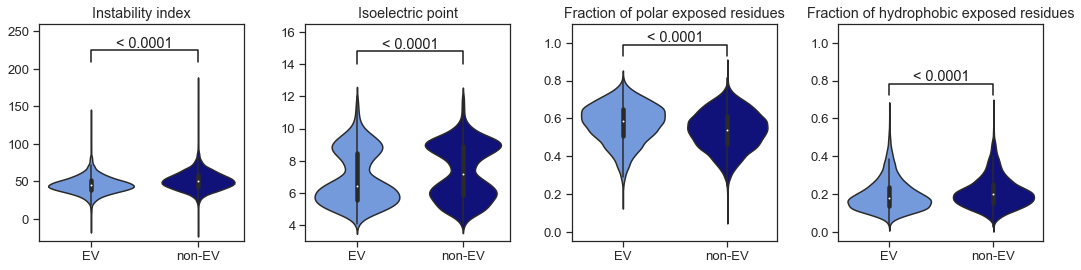

In [25]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, sharey=False, figsize=(18, 4))

feature='Instability_index'
sns.violinplot(x=labels[0], y=feature, data=dataset, ax=ax1, order=[1, 0], palette=my_pal)
ax1.set(ylabel=None, xlabel=None, title="Instability index", xticklabels=(labels), ylim=(-30, 260))
y, h, col = dataset[feature].max() + 25, 15, 'k'
ax1.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
ax1.text((x1+x2)*.5, y+h, print_p_val(p_vals_comb_none.loc[feature, "p_value_adjusted"]), ha='center', va='bottom', color=col)

feature='isoelectric_point'
sns.violinplot(x=labels[0], y=feature, data=dataset, ax=ax2, order=[1, 0], palette=my_pal)
ax2.set(ylabel=None, xlabel=None, title="Isoelectric point", xticklabels=(labels), ylim=(3, 16.5))
y, h, col = dataset[feature].max() + 2, 0.8, 'k'
ax2.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
ax2.text((x1+x2)*.5, y+h, print_p_val(p_vals_comb_none.loc[feature, "p_value_adjusted"]), ha='center', va='bottom', color=col)

feature='Polar_exposed'
sns.violinplot(x=labels[0], y=feature, data=dataset, ax=ax3, order=[1, 0], palette=my_pal)
ax3.set(ylabel=None, xlabel=None, title="Fraction of polar exposed residues", xticklabels=(labels), ylim=(-0.05, 1.1))
y, h, col = dataset[feature].max() + 0.05, 0.06, 'k'
ax3.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
ax3.text((x1+x2)*.5, y+h, print_p_val(p_vals_comb_none.loc[feature, "p_value_adjusted"]), ha='center', va='bottom', color=col)

feature='Hydrophobic_exposed'
sns.violinplot(x=labels[0], y=feature, data=dataset, ax=ax4, order=[1, 0], palette=my_pal)
ax4.set(ylabel=None, xlabel=None, title="Fraction of hydrophobic exposed residues", xticklabels=(labels), ylim=(-0.05, 1.1))
y, h, col = dataset[feature].max() + 0.05, 0.06, 'k'
ax4.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
ax4.text((x1+x2)*.5, y+h, print_p_val(p_vals_comb_none.loc[feature, "p_value_adjusted"]), ha='center', va='bottom', color=col)


plt.subplots_adjust(wspace = 0.3)
plt.show()

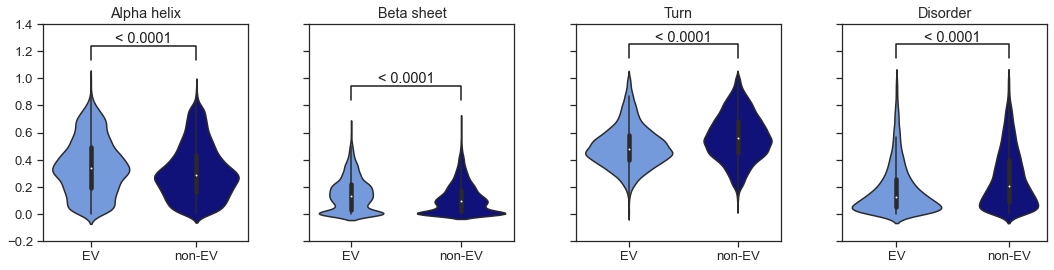

In [26]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, sharey=True, figsize=(18, 4))
plt.ylim((-0.2, 1.4))

feature='helix'
sns.violinplot(x=labels[0], y=feature, data=dataset, ax=ax1, order=[1, 0], palette=my_pal)
ax1.set(ylabel=None, xlabel=None, title="Alpha helix", xticklabels=(labels))
y, h, col = dataset[feature].max() + 0.15, 0.1, 'k'
ax1.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
ax1.text((x1+x2)*.5, y+h, print_p_val(p_vals_comb_none.loc[feature, "p_value_adjusted"]), ha='center', va='bottom', color=col)

feature='sheet'
sns.violinplot(x=labels[0], y=feature, data=dataset, ax=ax2, order=[1, 0], palette=my_pal)
ax2.set(ylabel=None, xlabel=None, title="Beta sheet", xticklabels=(labels))
y, h, col = dataset[feature].max() + 0.15, 0.1, 'k'
ax2.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
ax2.text((x1+x2)*.5, y+h, print_p_val(p_vals_comb_none.loc[feature, "p_value_adjusted"]), ha='center', va='bottom', color=col)

feature='turn'
sns.violinplot(x=labels[0], y=feature, data=dataset, ax=ax3, order=[1, 0], palette=my_pal)
ax3.set(ylabel=None, xlabel=None, title="Turn", xticklabels=(labels))
y, h, col = dataset[feature].max() + 0.15, 0.1, 'k'
ax3.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
ax3.text((x1+x2)*.5, y+h, print_p_val(p_vals_comb_none.loc[feature, "p_value_adjusted"]), ha='center', va='bottom', color=col)

feature='disorder'
sns.violinplot(x=labels[0], y=feature, data=dataset, ax=ax4, order=[1, 0], palette=my_pal)
ax4.set(ylabel=None, xlabel=None, title="Disorder", xticklabels=(labels))
y, h, col = dataset[feature].max() + 0.15, 0.1, 'k'
ax4.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
ax4.text((x1+x2)*.5, y+h, print_p_val(p_vals_comb_none.loc[feature, "p_value_adjusted"]), ha='center', va='bottom', color=col)

plt.subplots_adjust(wspace = 0.3)
plt.show()